In [6]:
import illustris_python as il
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import random
import matplotlib.patches as patches
import numpy as np
from scipy import integrate
from scipy.optimize import fsolve
import os,matplotlib
import time,pickle,_pickle
import matplotlib.pyplot as plt
from matplotlib.pylab import rc
import os
import h5py
import math
import os.path
import tensorflow as tf
import keras

import pickle
tf.enable_eager_execution()
tf.VERSION
AUTOTUNE = tf.data.experimental.AUTOTUNE



def log10(x):
    if x > 0:
        return math.log10(x)
    else:
        return -np.inf


def exp(x):
    try:
        return math.exp(x)
    except:
        return np.inf


# calculate L_lim:
M_sun = 4.53
M_apparent_lim = 24

# distance in pc:
distance = 324.67 * 1e6

# apparent magnitude
M_lim = 24 - 5 * (log10(distance) - 1)
# print(M_lim)
M_sun = 4.53
# L_lim in unit of L_sun

L_lim = 10 ** ((M_lim - M_sun) / (-2.5))


# r band magnitude
def M_to_L_r_band(Mr):
    return 10 ** ((Mr - M_sun) / (-2.5))


def log10(x):
    if x > 0:
        return math.log10(x)
    else:
        return np.nan

def box_smooth(data_array):
    N = len(data_array)

    data_smooth = []

    for i in range(0, N):
        data_i = data_array[int(np.maximum(i - 1, 0)):int(np.minimum(i + 2, N))]
        # print(np.nanmean(data_i))

        data_smooth.append(np.nanmean(data_i))

    data_smooth = np.array(data_smooth).ravel()
    data_smooth[0] = np.nanmedian(data_array[:1])
    return data_smooth

def bootstrap_scatter_err(samples):
    mask_finite = np.isfinite(samples)
    samples = samples[mask_finite]
    index_all = range(len(samples))
    err_all = []
    N=100
    for i in range(0,N):
        index_choose = np.random.randint(0,len(samples)-1,len(samples))
        # k_i = np.nanstd(samples[index_choose])
        k_i = np.percentile(samples[index_choose],84)-np.percentile(samples[index_choose],16)
        k_i = k_i/2
        err_all.append(k_i)
    err_all = np.array(err_all)
    if len(samples)<0:
        err_all = np.nan

    return err_all


def exp(x):
    try:
        return math.exp(x)
    except:
        return np.inf

def Mpeak_log_to_Vpeak_log(Mpeak_log):
    return 0.3349*Mpeak_log - 1.672

G = 4.301 * 10 ** (-9)
cons = (4 * G * np.pi / (3 * (1 / 24 / (1.5 * 10 ** (11))) ** (1 / 3))) ** 0.5


def calculate_v_dispersion(Mh):
    return Mh ** (1 / 3) * cons


exp = np.vectorize(exp)
log10 = np.vectorize(log10)

####!!!!!!! here are some extreme values:
## Let's use 99 percent of data:


def normalize(x,return_maxmin=False):

    temp_max = np.nanpercentile(x,99)
    temp_min = np.nanpercentile(x, 1)

    if return_maxmin:
        return 2 * (x - temp_min) / (temp_max - temp_min) - 1,temp_max,temp_min
    else:
        return 2 * (x - temp_min) / (temp_max - temp_min) - 1



plot_path = "/Users/caojunzhi/Downloads/upload_201909_Jeremy/"


if os.path.isdir("/Volumes/SSHD_2TB") == True:
    print("The code is on Spear of Adun")

    ## Move to Data_10TB
    data_path = "/Volumes/Data_10TB/"

elif os.path.isdir("/mount/sirocco1/jc6933/test") == True:
    data_path = "/mount/sirocco2/jc6933/Data_sirocco/"
    print("The code is on Sirocco")

# Kratos
elif os.path.isdir("/home/jc6933/test_kratos") == True:
    data_path = "/mount/kratos/jc6933/Data/"
    print("The code is on Kratos")

# Void Seeker
elif os.path.isdir("/home/jc6933/test_Void_Seeker") == True:
    data_path = "/mount/Void_Seeker/Data_remote/"
    print("The code is on Void Seeker")

### PRINCE:
elif os.path.isdir("/home/jc6933/test_folder_prince") == True:
    data_path = "/scratch/jc6933/"
    print("The code is on PRINCE")

else:
    print("The code is on local")
    data_path = "/Volumes/Extreme_SSD/Data/"

print("data_path %s" % data_path)


The code is on Void Seeker
data_path /mount/Void_Seeker/Data_remote/


# Read TNG data at different redshifts

In [7]:
# Let's read data from TNG:

# z=0:

n_group = 99

# read TNG300:


fields = ['GroupBHMass', "Group_M_Crit200", "GroupFirstSub","Group_R_Crit200","GroupSFR","GroupCM"]

basePath = data_path + 'TNG100/TNG300-1/output'
halos = il.groupcat.loadHalos(basePath, n_group, fields=fields)
halos.keys()

GroupBHMass = halos['GroupBHMass'] * 1e10 / 0.704
Group_M_Crit200 = halos["Group_M_Crit200"] * 1e10 / 0.704
GroupFirstSub = halos["GroupFirstSub"]
R_vir_z0 = halos["Group_R_Crit200"]/ 0.704
GroupSFR = halos["GroupSFR"]
GroupCM = halos["GroupCM"]
### for subhalo
# Use this to derive the index for the subhalo:
# Index into the Group table of the FOF host/parent of this Subhalo.

fields = ['SubhaloMass', 'SubhaloSFR', "SubhaloVmax", "SubhaloStellarPhotometricsMassInRad", "SubhaloBHMass",
          "SubhaloGrNr","SubhaloSpin","SubhaloVelDisp","SubhaloStellarPhotometrics","SubhaloCM","SubhaloStarMetalFractions"]

basePath = data_path + 'TNG100/TNG300-1/output'
subhalos = il.groupcat.loadSubhalos(basePath, n_group, fields=fields)
subhalos.keys()

mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704
Vmax = subhalos['SubhaloVmax']
SubhaloStellarPhotometricsMassInRad = subhalos['SubhaloStellarPhotometricsMassInRad'] * 1e10 / 0.704
SubhaloStellarPhotometrics = subhalos['SubhaloStellarPhotometrics']
SubhaloBHMass = subhalos["SubhaloBHMass"] * 1e10 / 0.704
SubhaloCM = subhalos["SubhaloCM"]
SubhaloVelDisp = subhalos["SubhaloVelDisp"]
SubhaloStarMetalFractions = subhalos["SubhaloStarMetalFractions"]
SubhaloSFR = subhalos["SubhaloSFR"]
# index
SubhaloGrNr = subhalos["SubhaloGrNr"]

Vmax_halo_z0 = Vmax[GroupFirstSub]
Ms_halo_z0_log = log10(SubhaloStellarPhotometricsMassInRad[GroupFirstSub])
Mh_log_z0 = log10(Group_M_Crit200)
BH_mass_z0 = SubhaloBHMass[GroupFirstSub]

magnitude_r = SubhaloStellarPhotometrics[:,5]
L_r = M_to_L_r_band(magnitude_r)

mask = Ms_halo_z0_log>8.0
N = len(Ms_halo_z0_log[mask])

print("Finish reading data")



Finish reading data


/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater


In [8]:
# Use group first sub to detect central or satellites:
# If the index is -1, it's not what we need:
mask_central = list(set(GroupFirstSub)-set([-1]))
mask_sat = set(np.arange(0,len(SubhaloSFR)-1))-set(GroupFirstSub)
mask_sat = list(mask_sat)

In [9]:
# sanity check:
print(len(SubhaloSFR),len(mask_central),len(mask_sat),len(mask_central)+len(mask_sat))

14485709 11504190 2981519 14485709


# Let's construct central and satellite using p_cen: p_cen=1 for central and p_cen=0 for satellites

# Include Ms, SFR, SubhaloStellarPhotometrics (8), and metallicity (10)

In [10]:
# use log scale in both Ms and SFR!
fusion_all = np.c_[log10(SubhaloStellarPhotometricsMassInRad),log10(SubhaloSFR),log10(Vmax),log10(SubhaloVelDisp),SubhaloStellarPhotometrics,log10(SubhaloStarMetalFractions)]
fusion_central = fusion_all[mask_central,:]
fusion_sat = fusion_all[mask_sat,:]
p_cen = np.append(np.ones(len(mask_central)),np.zeros(len(mask_sat)))



In [11]:
X = np.r_[fusion_central,fusion_sat]
y = p_cen

## only select samples with logMs>1e8 ?
#mask_7 = (X[:,0]>9)&(X[:,0]<11)
# drop data with missing values:
# fit diffeent model for different logMs
mask_7 = (X[:,0]>8)&(X[:,0]<9)
X = X[mask_7,:]
y = y[mask_7]



# split train and test. Do shuffle:

(array([2.4000e+01, 5.2200e+02, 8.6260e+03, 4.4967e+04, 7.9965e+04,
        4.0017e+04, 9.6310e+03, 3.5890e+03, 6.4400e+02, 7.6000e+01]),
 array([-4.52431195, -4.34667713, -4.16904231, -3.99140749, -3.81377267,
        -3.63613786, -3.45850304, -3.28086822, -3.1032334 , -2.92559858,
        -2.74796376]),
 <a list of 10 Patch objects>)

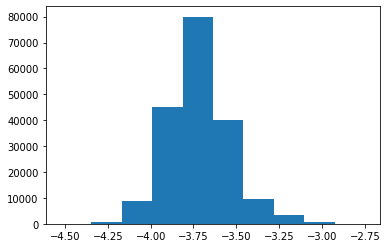

In [12]:
# sanity check
plt.hist(X[:,-1])

In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.2,shuffle=True)

# Let's start with a gradient boost tree:


In [14]:
### XGBOOST:
import time
# try xgboost:
from xgboost import XGBClassifier
from xgboost import plot_importance
import pandas as pd

label_names = ["Ms_log","SFR_log","Vmax_log","V_disp_log","U", "B", "V", "K", "g", "r", "i", "z","H", "He", "C", "N", "O", "Ne", "Mg", "Si", "Fe", "total_metallicity"]


In [15]:

time_start = time.time()
params={}
params['booster'] = "gbtree"
#params['learning_rate'] = 0.02
###params['max_depth'] = 12
params['gpu_id'] = 0
#params["subsample"] = 0.85
params['max_bin'] = 512
params['tree_method'] = 'gpu_hist'

## Add a combination of L1 and L2 regularization will help us to prevent overfitting

# L1 regularization
#params['reg_alpha'] = 0.15
# L2 regularization
#params['reg_lamdba'] = 0.85


model = XGBClassifier(n_estimators=5000,verbose=2,n_jobs=-1,**params)
print("Doing gradient boost tree with GPU")
X_train = pd.DataFrame(data=X_train, columns=label_names)
model.fit(X_train,y_train)
# predict:


print("Time it takes using GPU=%.2f"%(time.time()-time_start))


X_test = pd.DataFrame(data=X_test, columns=label_names)
Y_predict_test = model.predict(X_test)

mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))



Doing gradient boost tree with GPU
Time it takes using GPU=24.13
Good=32354 Bad=5259
Accuracy=0.8602 for testing set


AUROC: 0.9274


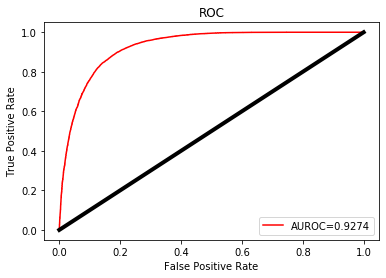

In [16]:
# plot AUROC curve:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib.pylab import rc


def confusion_matrix(y_pred, y_true):
    TP = len(y_pred[(y_pred == 1) & (y_true == 1)])
    TN = len(y_pred[(y_pred == 1) & (y_true == 0)])
    # type1 error : false alarm
    FP = len(y_pred[(y_pred == 1) & (y_true == 0)])
    # type 2 error. Fail to make alarm
    FN = len(y_pred[(y_pred == 0) & (y_true == 1)])

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    accuracy = (TP + TN) / len(y_pred)

    f1_score = 2 / (1 / precision + 1 / recall)
    return TP, TN, FP, FN, recall, precision, accuracy, f1_score


testy = y_test
prob = model.predict_proba(X_test)
probs = prob[:, 1]

auc = roc_auc_score(testy, probs)
print('AUROC: %.4f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(testy, probs)


plt.plot(fpr, tpr, color='r', label='AUROC=%.4f' % auc)
plt.plot([0, 1], [0, 1], color='k', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()


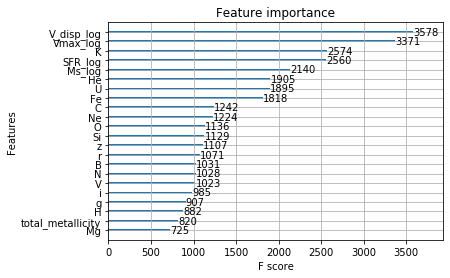

In [17]:
# plot the importance for different parameters:
plot_importance(model)

([array([16354.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 21259.]),
  array([14887.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 22726.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

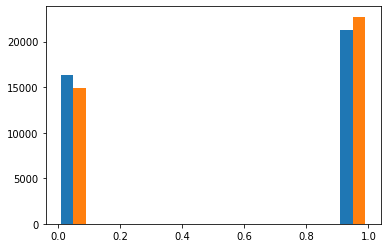

In [18]:
# histogram of y_test and y_predicted:
plt.hist(np.c_[y_test,Y_predict_test])


(array([ 9163.,  1603.,  1378.,  1364.,  1375.,  1552.,  1807.,  2653.,
         4894., 11824.]),
 array([1.8731336e-12, 9.9959582e-02, 1.9991916e-01, 2.9987875e-01,
        3.9983833e-01, 4.9979791e-01, 5.9975749e-01, 6.9971710e-01,
        7.9967666e-01, 8.9963627e-01, 9.9959582e-01], dtype=float32),
 <a list of 10 Patch objects>)

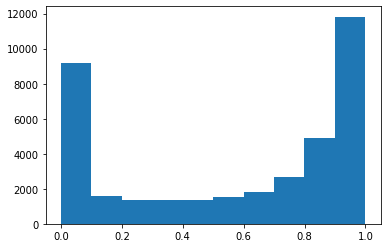

In [19]:
plt.hist(probs)

# also try Neural network
(coming soon)

In [20]:
"""


# A simple example of Neural network. This basic neural network doesn't include any
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X.shape[1],)),  # must declare input shape
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(250,activation="sigmoid"),
    tf.keras.layers.Dropout(rate=0.1),
tf.keras.layers.Dense(100,activation="sigmoid"),
tf.keras.layers.Dropout(rate=0.1),

])
# third layer
# 2 output labels: 1 for host-halo and 0 for subhalo
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))




# adam for Gradient boost
model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])


model.summary()

batch_size = 256

int_step = int(len(y_train)/batch_size)+1

X = np.r_[fusion_central,fusion_sat]
y = p_cen


## only select samples with logMs>1e8 ?
#mask_7 = (X[:,0]>9)&(X[:,0]<11)
# drop data with missing values:
# fit diffeent model for different logMs
mask_7 = (X[:,0]>8)
X = X[mask_7,:]
y = y[mask_7]




"""


# remove nan values with mean
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
#X_train.replace([-np.inf,np.inf],np.nan,inplace=True)
X_train = my_imputer.fit_transform(X_train)

X_test = my_imputer.fit_transform(X_test)



"""

# make sure there is no nan values
assert not np.any(np.isnan(X_train))

# 10 is good enough

num_steps=10
training_history = model.fit(X_train,y_train,validation_split=0.1,batch_size=batch_size, epochs=num_steps,steps_per_epoch=int_step,shuffle=True)

print(training_history.history.keys())
## test:
y_p = model.predict_classes(X_test).ravel()
mask_good = abs(y_p-y_test)<0.05
print(len(y_test[mask_good]),len(y_test))


print("Validation")

Y_predict_test = model.predict_classes(X_test)
Y_predict_test = Y_predict_test.ravel()
mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))




prob = model.predict_proba(X_test)
probs = prob[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUROC: %.4f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(y_test, probs)


plt.plot(fpr, tpr, color='r', label='AUROC=%.4f' % auc)
plt.plot([0, 1], [0, 1], color='k', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()


"""

'\n\n# make sure there is no nan values\nassert not np.any(np.isnan(X_train))\n\n# 10 is good enough\n\nnum_steps=10\ntraining_history = model.fit(X_train,y_train,validation_split=0.1,batch_size=batch_size, epochs=num_steps,steps_per_epoch=int_step,shuffle=True)\n\nprint(training_history.history.keys())\n## test:\ny_p = model.predict_classes(X_test).ravel()\nmask_good = abs(y_p-y_test)<0.05\nprint(len(y_test[mask_good]),len(y_test))\n\n\nprint("Validation")\n\nY_predict_test = model.predict_classes(X_test)\nY_predict_test = Y_predict_test.ravel()\nmask_good = abs(Y_predict_test-y_test)<0.01\n\nprint("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))\n\nprint("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))\n\n\n\n\nprob = model.predict_proba(X_test)\nprobs = prob[:, 1]\n\nauc = roc_auc_score(y_test, probs)\nprint(\'AUROC: %.4f\' % auc)\n\n## draw ROC:\nfpr, tpr, thresholds = roc_curve(y_test, probs)

# k mean clustering:
# Use this to pre-process the data and make ensemble modeling

In [21]:
from sklearn.cluster import KMeans


X = np.r_[fusion_central,fusion_sat]
y = p_cen

mask_7 = (X[:,0]>0)
X = X[mask_7,:]
y = y[mask_7]




kmeans = KMeans(n_clusters=4,n_jobs=-1)
mask_finite = np.isfinite(np.sum(X,axis=1))
kmeans.fit(X[mask_finite,:])
y_kmeans = kmeans.predict(X[mask_finite,:])

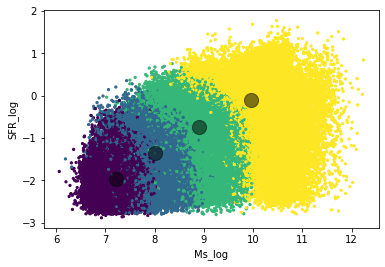

In [22]:
# check clustering properties:

x_name = 0
y_name = 1


plt.scatter(X[mask_finite, x_name], X[mask_finite, y_name], c=y_kmeans, s=5, cmap='viridis')
plt.xlabel("%s"%label_names[x_name])
plt.ylabel("%s"%label_names[y_name])
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [23]:
# Find best k:
# Also scale to 0-1 for all values
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(X[mask_finite,:])
data_transformed = mms.transform(X[mask_finite,:])

Sum_of_squared_distances = []
K = np.arange(1,15)
for k in K:
    print("Doing %d of %d"%(k,len(K)))
    km = KMeans(n_clusters=k,n_jobs=-1)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

Doing 1 of 14
Doing 2 of 14
Doing 3 of 14
Doing 4 of 14
Doing 5 of 14
Doing 6 of 14
Doing 7 of 14
Doing 8 of 14
Doing 9 of 14
Doing 10 of 14
Doing 11 of 14
Doing 12 of 14
Doing 13 of 14
Doing 14 of 14


Text(0, 0.5, 'sum of squared distance in group')

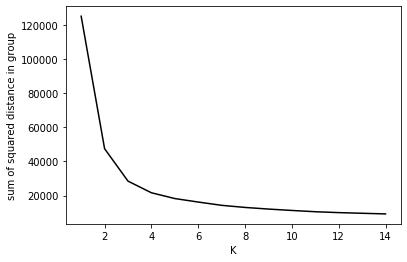

In [24]:
# plot:
plt.plot(K,Sum_of_squared_distances,"k")
plt.xlabel("K")
plt.ylabel("sum of squared distance in group")

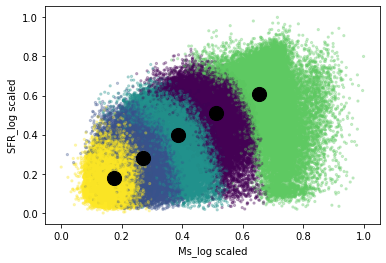

In [25]:
# Choose group k=5:

kmeans = KMeans(n_clusters=5,n_jobs=-1)

kmeans.fit(data_transformed)
y_kmeans = kmeans.predict(data_transformed)
# check clustering properties:

x_name = 0
y_name = 1


plt.scatter(data_transformed[:, x_name], data_transformed[:, y_name], c=y_kmeans, s=5, cmap='viridis', alpha=0.3)
plt.xlabel("%s scaled"%label_names[x_name])
plt.ylabel("%s scaled"%label_names[y_name])
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1)

# Let's try k clustring first, and Do xgboost in these clusters:
Coming soon!

### 